In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
event_seq_NL= "../../data_brute/event sequencage - pedagogie emergente.csv"
info_NL= "../../data_brute/informations - pedagogie emergente.csv"
tracking_NL= "../../data_brute/tracking GPS - pedagogie emergente.csv"

df_events= pd.read_csv(event_seq_NL, sep=";")
df_infos = pd.read_csv(info_NL, sep=";")
df_tracking = pd.read_csv(tracking_NL)

C:\Users\Ousmane Kontao\AppData\Local\Temp\ipykernel_123396\2199026724.py:7: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tracking = pd.read_csv(tracking_NL)


#### 1) df_infos

In [3]:
print(f"Le dataframe avec les informations sur le GPS et l'Id du joueur: \n {df_infos[:]}")
print()
df_infos.info()
print()

Le dataframe avec les informations sur le GPS et l'Id du joueur: 
    Team  GPS  ID
0   Att    8   2
1   Att    9   4
2   Att    2   5
3   Att    3   6
4   Att   15   1
5   Att   24   3
6   Def    4  11
7   Def    6  15
8   Def   13  13
9   Def   19  12
10  Def   16  16
11  Def   18  14

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Team    12 non-null     object
 1   GPS     12 non-null     int64 
 2   ID      12 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 420.0+ bytes



Nous avons une équipe d'attaque de 6 joueurs et une équipe de défense de 6 joueurs également identifié par leur numero de boite GPS et leur id 

Que faire avec ces infos ? 

In [4]:
gps_to_id = dict(zip(df_infos['GPS'], df_infos['ID']))
id_to_team = dict(zip(df_infos["ID"], df_infos["Team"]))
print(f"Nous allons utiliser ce dictionnaire pour faire la correspondance entre le numéro de GPS et l'id du joueur:\n{gps_to_id} ")
print()
print(f"Id vers équipe pour savoir si c'eest l'attaque ou la defense:\n{id_to_team}")

Nous allons utiliser ce dictionnaire pour faire la correspondance entre le numéro de GPS et l'id du joueur:
{8: 2, 9: 4, 2: 5, 3: 6, 15: 1, 24: 3, 4: 11, 6: 15, 13: 13, 19: 12, 16: 16, 18: 14} 

Id vers équipe pour savoir si c'eest l'attaque ou la defense:
{2: 'Att', 4: 'Att', 5: 'Att', 6: 'Att', 1: 'Att', 3: 'Att', 11: 'Def', 15: 'Def', 13: 'Def', 12: 'Def', 16: 'Def', 14: 'Def'}


In [5]:
df_infos[df_infos["GPS"] == 12]

,Team,GPS,ID


In [6]:
df_infos[df_infos["GPS"] == 8]

,Team,GPS,ID
0,Att,8,2


Cela nous permettra de relier les données tracking aux évenements

#### 2) df_tracking

In [7]:
df_tracking = df_tracking.drop(columns="Unnamed: 0", axis=1)
df_tracking.dropna(subset=["Player"])
df_tracking = df_tracking[(df_tracking["Player"] != "Ball") & (df_tracking["ID"] != "Ball")]
df_tracking["Player"] = df_tracking["Player"].fillna(0).astype(int)

In [20]:
df_tracking

,Possession,GPS,Time,X,Y,Team,Player,Frame,Position,ID
0,1,12,0.24,-4.859677,-10.750143,Att,3,2.0,240.0,3
1,1,12,0.26,-4.820556,-10.794123,Att,3,2.0,260.0,3
2,1,12,0.28,-4.781435,-10.838104,Att,3,2.0,280.0,3
3,1,12,0.30,-4.742313,-10.882084,Att,3,3.0,300.0,3
4,1,12,0.32,-4.689796,-10.925258,Att,3,3.0,320.0,3
...,...,...,...,...,...,...,...,...,...,...
205044,43,40,2178.76,6.537534,4.306865,Def,16,21787.0,2178760.0,1
205045,43,40,2178.78,6.537037,4.309762,Def,16,21787.0,2178780.0,1
205046,43,40,2178.80,6.536541,4.312658,Def,16,21788.0,2178800.0,1
205047,43,40,2178.82,6.540923,4.313410,Def,16,21788.0,2178820.0,1


In [8]:
df_tracking.dtypes

Possession      int64
GPS            object
Time          float64
X             float64
Y             float64
Team           object
Player          int64
Frame         float64
Position      float64
ID             object
dtype: object

J'ai viré tous les lignes avec la ball dans la colonne Player car mon graphe ou mes animations peuvent croire que le ballon est un joueur... ce qui rendrait toutes les analyses fausses !

#### 3) df_events

In [9]:
df_events.head()

,Position,Possession,Condition,Serie,Defense,Cote,Passeur,Receveur,Contact,Pied,Resultat
0,37320,1,EMERGENT,PRE,OUVERT,GAUCHE,1.0,NaN,NaN,NaN,NaN
1,37960,1,EMERGENT,PRE,OUVERT,GAUCHE,NaN,2.0,NaN,NaN,NaN
2,39000,1,EMERGENT,PRE,OUVERT,GAUCHE,2.0,NaN,NaN,NaN,NaN
3,39760,1,EMERGENT,PRE,OUVERT,GAUCHE,NaN,5.0,NaN,NaN,NaN
4,41600,1,EMERGENT,PRE,OUVERT,GAUCHE,5.0,NaN,contact,NaN,NaN


In [10]:
df_events['Time_s'] = df_events['Position'] / 1000
df_events

,Position,Possession,Condition,Serie,Defense,Cote,Passeur,Receveur,Contact,Pied,Resultat,Time_s
0,37320,1,EMERGENT,PRE,OUVERT,GAUCHE,1.0,NaN,NaN,NaN,NaN,37.32
1,37960,1,EMERGENT,PRE,OUVERT,GAUCHE,NaN,2.0,NaN,NaN,NaN,37.96
2,39000,1,EMERGENT,PRE,OUVERT,GAUCHE,2.0,NaN,NaN,NaN,NaN,39.00
3,39760,1,EMERGENT,PRE,OUVERT,GAUCHE,NaN,5.0,NaN,NaN,NaN,39.76
4,41600,1,EMERGENT,PRE,OUVERT,GAUCHE,5.0,NaN,contact,NaN,NaN,41.60
...,...,...,...,...,...,...,...,...,...,...,...,...
321,1810280,44,EMERGENT,POST,SERRE,DROITE,1.0,NaN,NaN,NaN,NaN,1810.28
322,1810880,44,EMERGENT,POST,SERRE,DROITE,NaN,4.0,NaN,NaN,NaN,1810.88
323,1815680,44,EMERGENT,POST,SERRE,DROITE,4.0,NaN,contact,NaN,NaN,1815.68
324,1816000,44,EMERGENT,POST,SERRE,DROITE,NaN,3.0,NaN,NaN,NaN,1816.00


C'est important de mettre le time parce que position contient le timecode des evenements en ms donc en le divisant par 1000 on peut synchroniser un événement avec le bon moment du tracking

In [11]:
df_events["Passeur"] = pd.to_numeric(df_events["Passeur"],  errors='coerce')
df_events['Receveur'] = pd.to_numeric(df_events["Receveur"], errors='coerce')

#### 4) Synchronisation des evenements et des trackings pour pourvoir visualiser une passe

Nous allons choisir une passe puis trouver les positions des joueurs sur le terrain a ce moment et tracer

In [12]:
tol = 0.5
# Pour cela il suffit de trouver une ligne ou le passeur n'est pas vide suivie directement d'une ligne ou le receveur n'est pas vide
for i in range(len(df_events) - 1):
    if pd.notna(df_events.loc[i, 'Passeur']) and pd.notna(df_events.loc[i + 1, 'Receveur']):
        time_pass = df_events.loc[i, 'Time_s']
        passeur = int(df_events.loc[i, 'Passeur'])
        receveur = int(df_events.loc[i + 1, 'Receveur'])

# maintenant je vais trouver les positions autour de cet instant        
        df_frame = df_tracking[(df_tracking['Time'] >= time_pass - tol) & (df_tracking['Time'] <= time_pass + tol)]
        df_frame_mean = df_frame.groupby("Player")[["X", "Y"]].mean().reset_index()
        df_frame_mean['Team'] = df_frame.groupby('Player')['Team'].first().values

        # Vérifier nombre de joueurs présents
        if len(df_frame_mean) >= 8:
            print(f"passe trouvée : {passeur} ---> {receveur} à {time_pass:.2f} s")#avec {len(df_frame_mean)} joueurs")
            break
if len(df_frame_mean) < 8:
    print("Pas de passe trouvée avec assez de joueurs")


passe trouvée : 1 ---> 6 à 316.84 s


In [13]:
df_frame_mean

,Player,X,Y,Team
0,1,8.931904,21.626352,Att
1,2,5.256298,37.259668,Att
2,3,11.488182,25.578008,Att
3,4,13.211641,18.654439,Att
4,5,11.536153,24.777786,Att
5,6,10.341427,13.138660,Att
6,11,10.629340,11.604198,Def
7,12,8.660703,32.566582,Def
8,13,9.883371,22.557837,Def
9,14,10.611290,16.819274,Def


#### visu ??

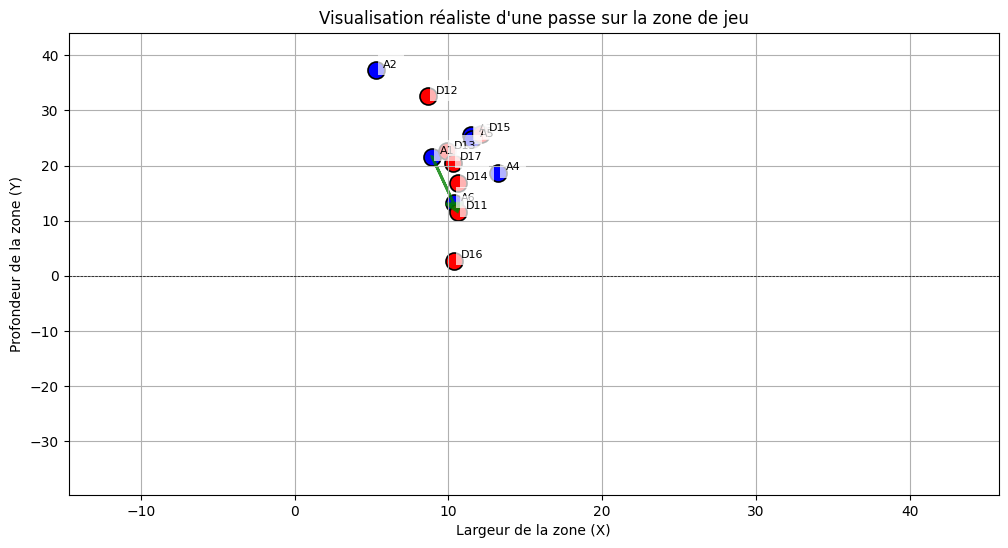

In [14]:
import matplotlib.pyplot as plt

x_min, x_max = df_tracking['X'].min() - 5, df_tracking['X'].max() + 5
y_min, y_max = df_tracking['Y'].min() - 5, df_tracking['Y'].max() + 5

plt.figure(figsize=(12, 6))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.title("Visualisation réaliste d'une passe sur la zone de jeu")

for _, row in df_frame_mean.iterrows():
    x, y = row['X'], row['Y']
    player = int(row['Player'])
    team = row['Team']
    color = 'blue' if team == 'Att' else 'red'
    label = f"A{player}" if team == 'Att' else f"D{player}"
    plt.scatter(x, y, color=color, s=150, alpha=1, edgecolors='k', linewidths=1.2)
    plt.text(x + 0.5, y + 0.5, label, fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

passeur_pos = df_frame_mean[df_frame_mean['Player'] == passeur][['X', 'Y']].mean()
receveur_pos = df_frame_mean[df_frame_mean['Player'] == receveur][['X', 'Y']].mean()

if not passeur_pos.isna().any() and not receveur_pos.isna().any():
    plt.arrow(passeur_pos['X'], passeur_pos['Y'],
              receveur_pos['X'] - passeur_pos['X'],
              receveur_pos['Y'] - passeur_pos['Y'],
              head_width=1.0, head_length=1.5, fc='green', ec='green', linewidth=2, alpha=0.8)

plt.xlabel("Largeur de la zone (X)")
plt.ylabel("Profondeur de la zone (Y)")
plt.grid(True)
plt.show()


#### Nous allons créer un graphe avec les noeuds (attaques et defenses) reliant les attaquants et les defenseurs des deux equipes par des aretes non orientés et orientés entre les attaquants

In [15]:
# tout d'abord filtrer un temps precis
t_cible = 316.84
seuil_passe = 6.0

# trouver la frame la plus proche

frame_cible = df_tracking.iloc[(df_tracking["Time"] - t_cible).abs().argsort()[:1]]["Frame"].values[0]

# ensuite extraire les positions a cette frame

df_frame = df_tracking[df_tracking['Frame'] == frame_cible].copy()

In [16]:
df_frame = df_frame[df_frame["ID"] != "Ball"]
df_frame["ID"] = df_frame["ID"].astype(int)

In [17]:
df_frame

,Possession,GPS,Time,X,Y,Team,Player,Frame,Position,ID
32597,8,12,316.80,11.162419,25.813430,Att,3,3168.0,316800.0,3
32598,8,12,316.82,11.281421,25.777183,Att,3,3168.0,316820.0,3
32599,8,12,316.84,11.400424,25.740936,Att,3,3168.0,316840.0,3
32600,8,12,316.86,11.519426,25.704689,Att,3,3168.0,316860.0,3
32601,8,12,316.88,11.638428,25.668442,Att,3,3168.0,316880.0,3
...,...,...,...,...,...,...,...,...,...,...
35273,8,40,316.80,10.336980,2.802579,Def,16,3168.0,316800.0,1
35274,8,40,316.82,10.336980,2.802579,Def,16,3168.0,316820.0,1
35275,8,40,316.84,10.336980,2.802579,Def,16,3168.0,316840.0,1
35276,8,40,316.86,10.336980,2.802579,Def,16,3168.0,316860.0,1


In [18]:
ball_carrier_id = 1 

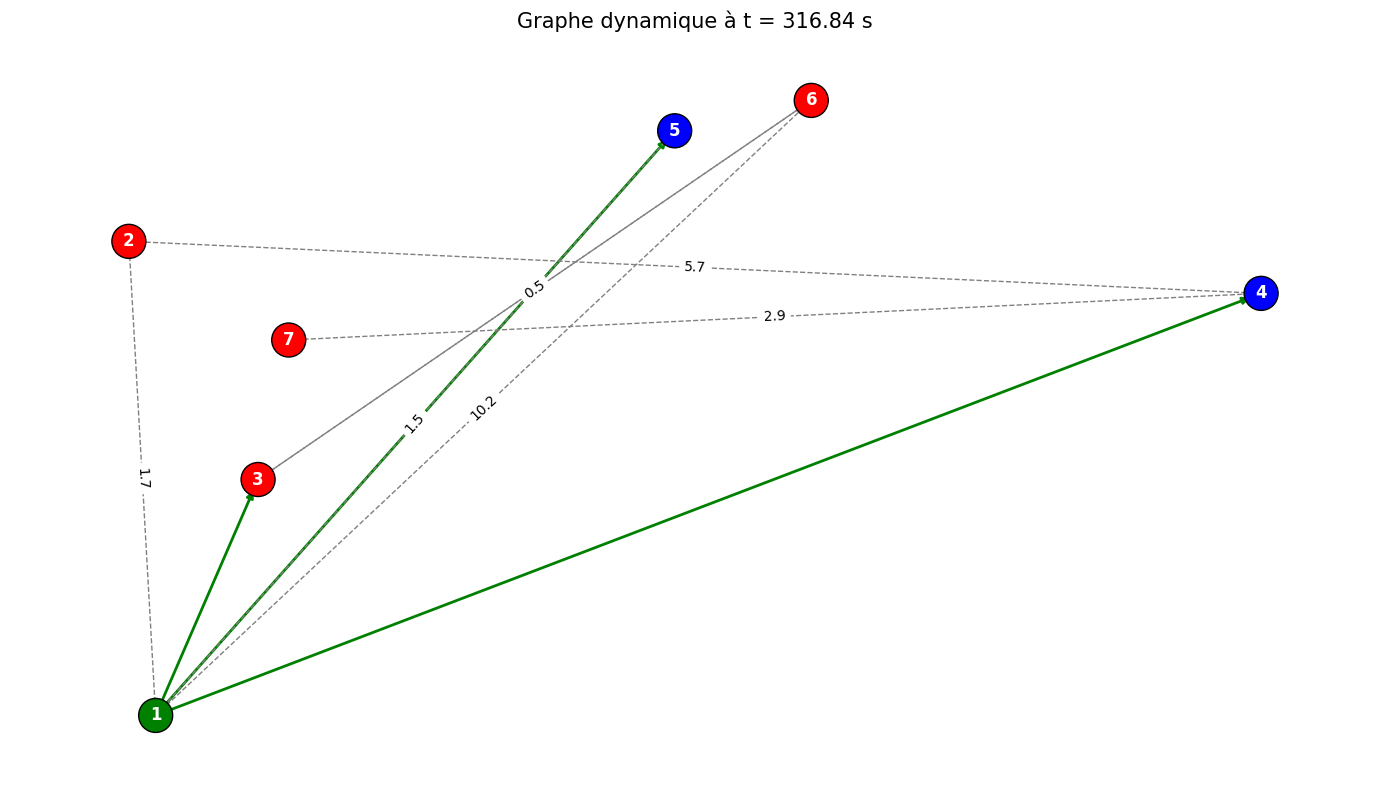

In [19]:
G = nx.DiGraph()
for _, row in df_frame.iterrows():
    G.add_node(int(row["ID"]),
               pos=(row["X"], row["Y"]),
               team=row["Team"],
               is_carrier=(row["ID"] == ball_carrier_id))

# === Séparer les joueurs ===
df_att = df_frame[(df_frame["Team"] == "Att")]
df_def = df_frame[(df_frame["Team"] == "Def")]
pos_carrier = df_att[df_att["ID"] == ball_carrier_id][["X", "Y"]].values[0]

# === Arêtes de passes (depuis le porteur uniquement) ===
for _, row in df_att.iterrows():
    if row["ID"] != ball_carrier_id:
        dist = np.linalg.norm(pos_carrier - np.array([row["X"], row["Y"]]))
        if dist <= seuil_passe:
            G.add_edge(ball_carrier_id, int(row["ID"]), type="passe")

# === Arêtes de pression (chaque défenseur vers joueur le plus proche) ===
for _, d in df_def.iterrows():
    d_pos = np.array([d["X"], d["Y"]])
    min_dist = float('inf')
    closest = None
    for _, a in df_att.iterrows():
        a_pos = np.array([a["X"], a["Y"]])
        dist = np.linalg.norm(d_pos - a_pos)
        if dist < min_dist:
            min_dist = dist
            closest = int(a["ID"])
    G.add_edge(int(d["ID"]), closest, type="pression", label=f"{min_dist:.1f}")

# === Affichage du graphe ===
pos = nx.get_node_attributes(G, 'pos')
color_map = [
    'green' if G.nodes[n].get('is_carrier') else
    ('blue' if G.nodes[n]['team'] == 'Att' else 'red')
    for n in G.nodes
]

plt.figure(figsize=(14, 8))
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=600, edgecolors='k')
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes}, font_color='white', font_weight='bold')

# Arêtes de passe (orientées en vert)
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, d in G.edges(data=True) if d["type"] == "passe"],
    edge_color="green", arrows=True, arrowstyle='-|>', width=2
)

# Arêtes de pression (non orientées en gris pointillés)
edges_pression = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "pression"]
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges_pression,
    style="dashed", edge_color="gray", arrows=False
)

# Labels de distance
labels_pression = {(u, v): d["label"] for u, v, d in G.edges(data=True) if d["type"] == "pression"}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_pression, font_color="black", font_size=10)

plt.title(f"Graphe dynamique à t = {t_cible:.2f} s", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()